# Drive-it DQN

## Model
\begin{equation}
l_1 = relu( x W_1 + b_1) \\
l_2 = relu( x W_2 + b_2) \\
l_3 = relu( x W_3 + b_3) \\
Q(s,a) = l_1 W_o + b_o \\
\end{equation}

In [1]:
import random, numpy, math
from cntk import *
from cntk.models import Sequential
from cntk.layers import *
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('ggplot')
%matplotlib inline
sns.set()

## Visualization
We use PCA decomposition on memory samples to visualize the $Q(s,a)$ values across the state space: 

In [2]:
def pca_plot(n=10000, alpha=1.0, size=5):
    _, samples = agent.memory.sample(n)
    states = np.array([ o[0] for o in samples ], dtype=np.float32)
    qsa = agent.brain.predict(states)[0]
    
    from sklearn import decomposition
    pca = decomposition.PCA(n_components=2)
    pca.fit(states)
    X = pca.transform(states)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    ax = axes[0,0]; plt.sca(ax);ax.set_title('Action')
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(qsa, 1), alpha=alpha, s=size, cmap="rainbow")
    ax = axes[0,1]; plt.sca(ax);ax.set_title('Q(s,no-change)')
    plt.scatter(X[:, 0], X[:, 1], c=qsa[:,0], alpha=alpha, s=size, cmap="rainbow")    
    ax = axes[1,0]; plt.sca(ax);ax.set_title('Q(s,left)')
    plt.scatter(X[:, 0], X[:, 1], c=qsa[:,1], alpha=alpha, s=size, cmap="rainbow")    
    ax = axes[1,1]; plt.sca(ax);ax.set_title('Q(s,right)')
    plt.scatter(X[:, 0], X[:, 1], c=qsa[:,2], alpha=alpha, s=size, cmap="rainbow")

For a more meaningful plot, just project sample across $x_m$ and $y_m$.

In [3]:
def slice_plot(n=10000, alpha=1.0, size=5):
    _, samples = agent.memory.sample(n)
    states = np.array([ o[0] for o in samples ], dtype=np.float32)
    qsa = agent.brain.predict(states)
    v = agent.brain.value.eval(states)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    ax = axes[0,0]; plt.sca(ax);ax.set_title('Action')
    plt.scatter(states[:, 0], states[:, 1], c=np.argmax(qsa[:,0], 1), alpha=alpha, s=size, cmap="rainbow")
    ax = axes[0,1]; plt.sca(ax);ax.set_title('Q(s,no-change)')
    plt.scatter(states[:, 0], states[:, 1], c=qsa[:,0,0], alpha=alpha, s=size, cmap="rainbow")    
    ax = axes[1,0]; plt.sca(ax);ax.set_title('Q(s,left)')
    plt.scatter(states[:, 0], states[:, 1], c=qsa[:,0,1], alpha=alpha, s=size, cmap="rainbow")    
    ax = axes[1,1]; plt.sca(ax);ax.set_title('Q(s,right)')
    plt.scatter(states[:, 0], states[:, 1], c=qsa[:,0,2], alpha=alpha, s=size, cmap="rainbow")
    axes[0,0].set_ylabel('$y_m$')
    axes[1,0].set_ylabel('$y_m$')
    axes[1,0].set_xlabel('$x_m$')
    axes[1,1].set_xlabel('$x_m$')

## Training

In [4]:
def run_episode(agent, render=False):
    o = env.reset()
    b = belief.reset(o[car])
    s = belief.normalize(b)
    R = 0
    actions = {}
    while True:            
        if render: env.render()

        a = agent.act(s.astype(np.float32))
        actions[car] = a
        o_, r, done, info = env.step(actions)
        b_ = belief.update(o_[car], env.dt)
        s_ = belief.normalize(b_)
        
        if done:
            s_ = None

        agent.observe((s, a, r[car], s_))
        s = s_
        R += r[car]

        if done:
            agent.endEpisode()
            return R

In [5]:
from DriveItMultiGym import DriveItEnv
from car import Car
from belief import PositionTracking
from agent import Agent

BATCH_SIZE = 20000

car = Car()
env = DriveItEnv([car], time_limit=10.0, noisy=False)
belief = PositionTracking(car)
stateCnt  = belief.observation_space.shape[0]
actionCnt = env.action_space.n
agent = Agent(stateCnt, actionCnt)

episode_number = 0
last_batch_episode = 0
last_batch_steps = 0
episodes = []
reward_sum = 0
reward_best = 18.0

(stateCnt, actionCnt)

(5, 9)

In [ ]:
while episode_number < 50000 and agent.steps < 1980000:
    episode_number += 1
    reward = run_episode(agent, render=False)
    reward_sum += reward
    
    if agent.steps >= last_batch_steps + BATCH_SIZE:
        reward_avg = reward_sum / (episode_number - last_batch_episode)
        last_batch_episode = episode_number
        last_batch_steps = int(agent.steps / BATCH_SIZE) * BATCH_SIZE
        episodes.append((episode_number, agent.steps, reward_avg))

        print('Episode: %d, steps: %d, epsilon: %f, average reward: %f.' \
              % (episode_number, agent.steps, agent.epsilon, reward_avg))
        
        if reward_avg > reward_best:
            reward_best = reward_avg
            agent.brain.model.save_model('best.mod')

        reward_sum = 0
       
agent.brain.model.save_model('last.mod')
print('Done.')

In [ ]:
from numpy import cos, sin, pi
median_radius = 0.375
line_length = 2.0 * median_radius
loop_median_length = 3.0 / 2.0 * pi * median_radius
checkpoint_median_length = line_length + loop_median_length

_, samples = agent.memory.sample(50000)
states = np.array([ o[0] for o in samples ], dtype=np.float32)
qmin = np.array([ o[-1] for o in samples ], dtype=np.float32)
qsa = agent.brain.predict(states)
v = agent.brain.value.eval(states)
a = agent.brain.advantage.eval(states)

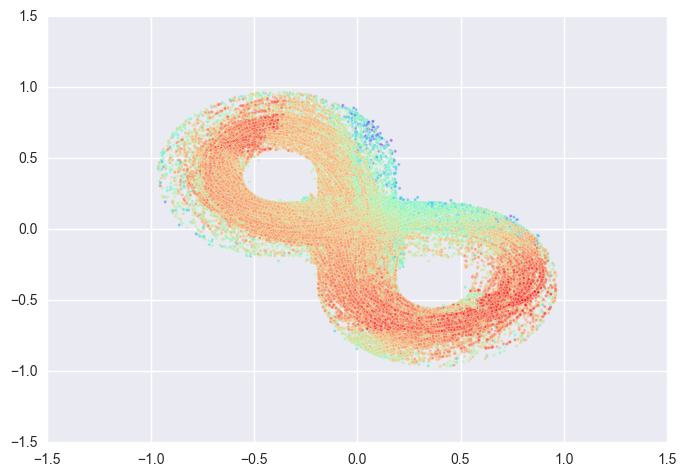

In [16]:
plt.scatter(states[:, 0], states[:, 1], c=v[:,0], alpha=0.5, s=5, cmap="rainbow")

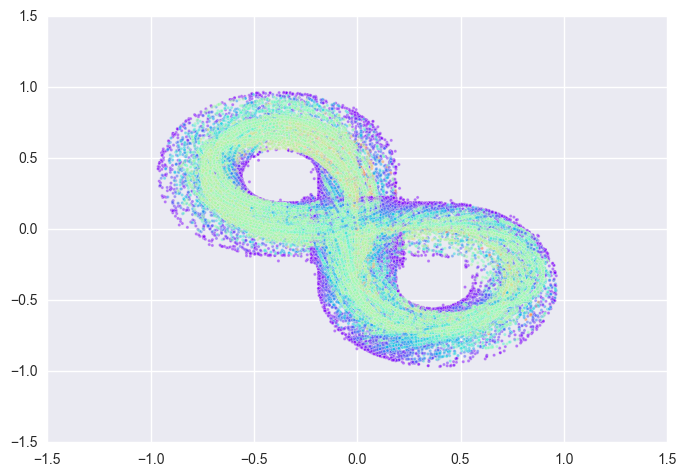

In [17]:
plt.scatter(states[:, 0], states[:, 1], c=qmin, alpha=0.5, s=5, cmap="rainbow")

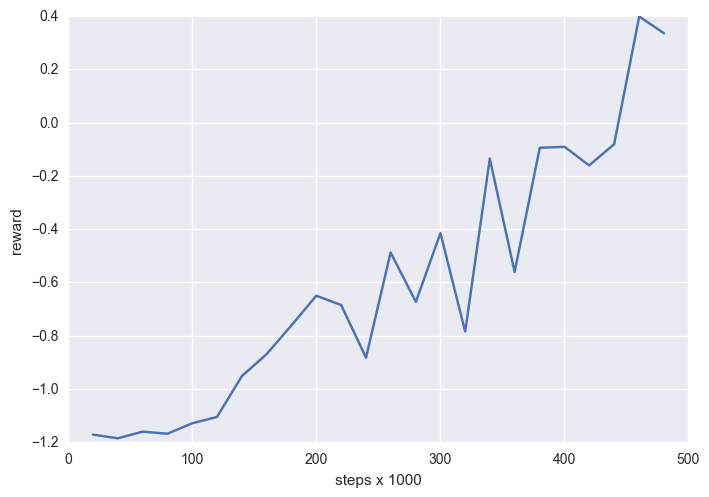

In [18]:
plt.plot([e[1]/1000 for e in episodes], [e[2] for e in episodes])
plt.xlabel('steps x 1000');plt.ylabel('reward')

In [26]:
coord = [DriveItEnv.median_to_cartesian(s[0]*checkpoint_median_length,s[1]*0.225) \
         for s in states]
x = [c[0] for c in coord]
y = [c[1] for c in coord]

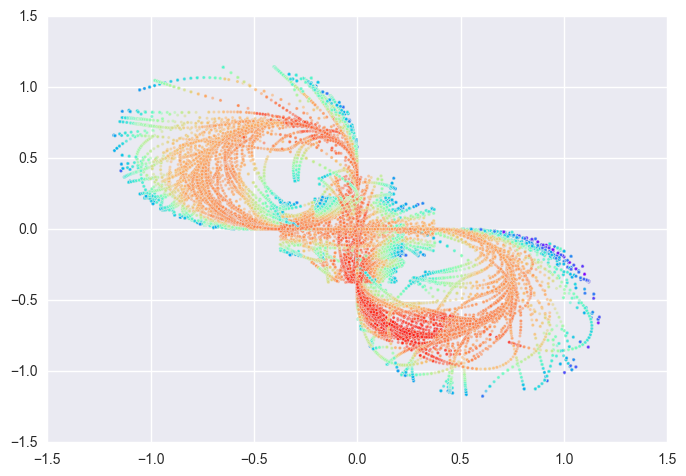

In [28]:
plt.scatter(x, y, c=v[:,0], alpha=0.5, s=5, cmap="rainbow")

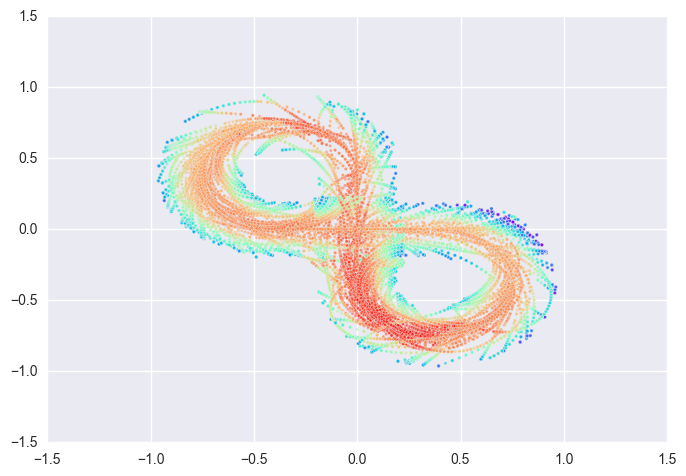

In [29]:
plt.scatter(states[:, 6], states[:, 7], c=v[:,0], alpha=0.5, s=5, cmap="rainbow")

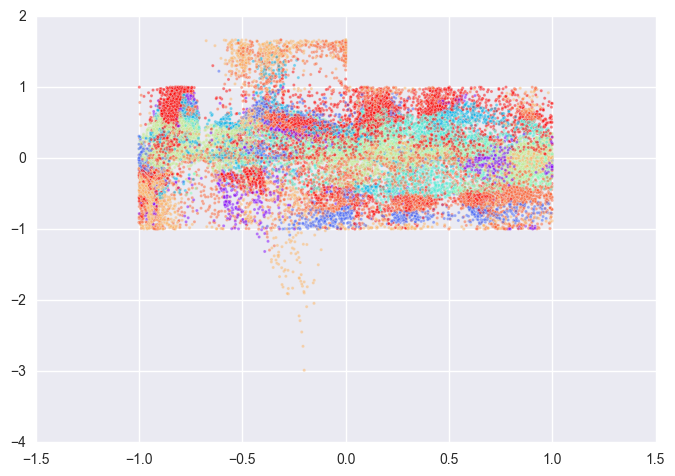

In [31]:
plt.scatter(states[:, 0], states[:, 1], c=np.argmax(qsa[:,0], 1), alpha=0.5, s=5, cmap="rainbow")

0


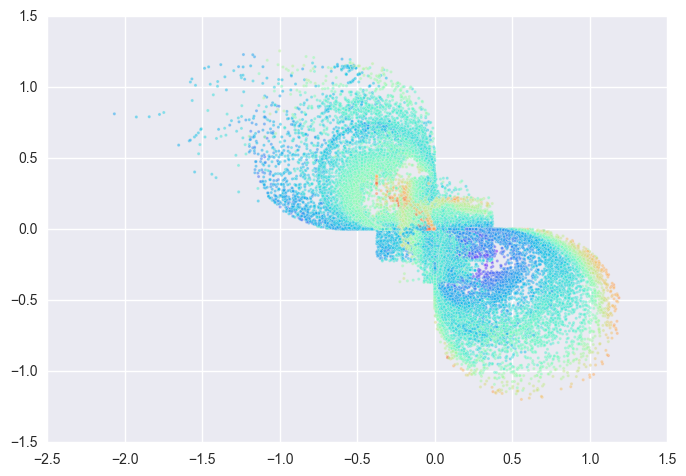

1


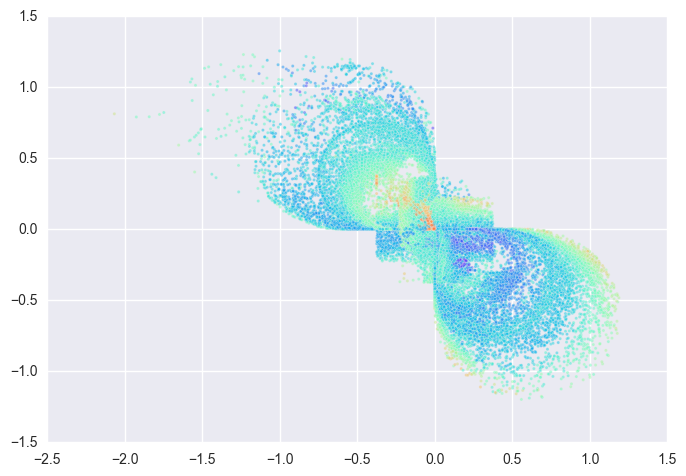

2


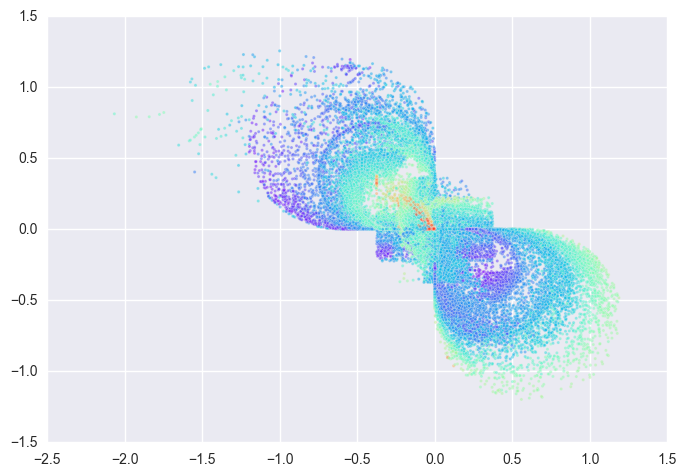

3


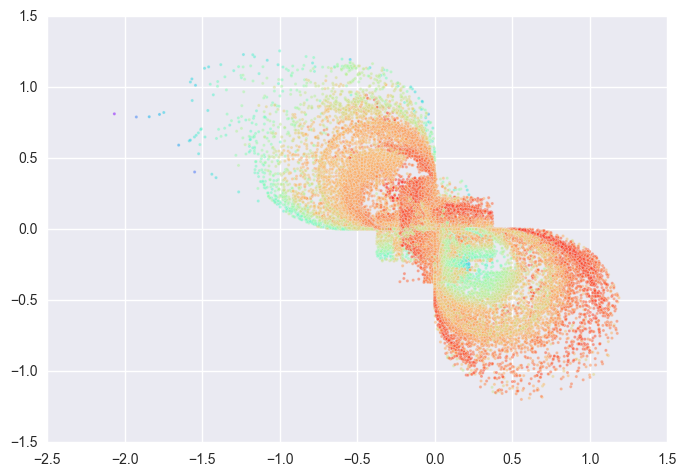

4


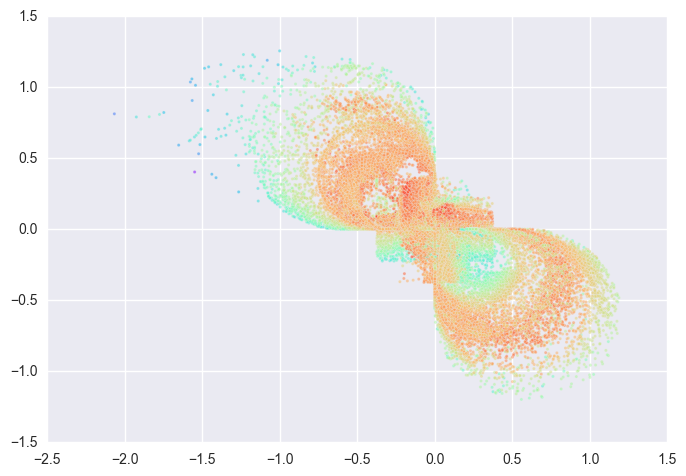

5


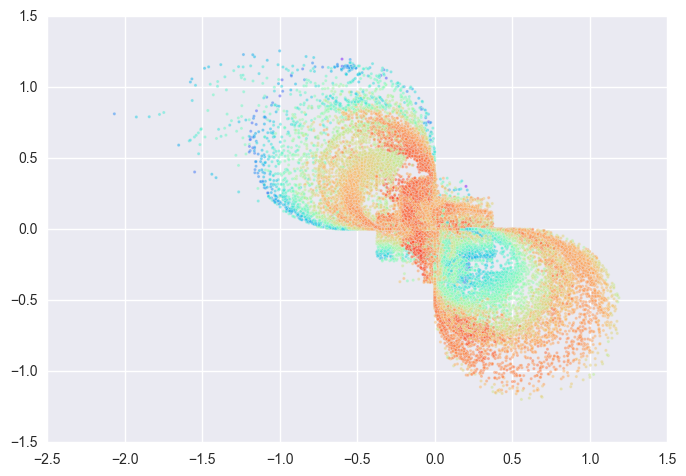

6


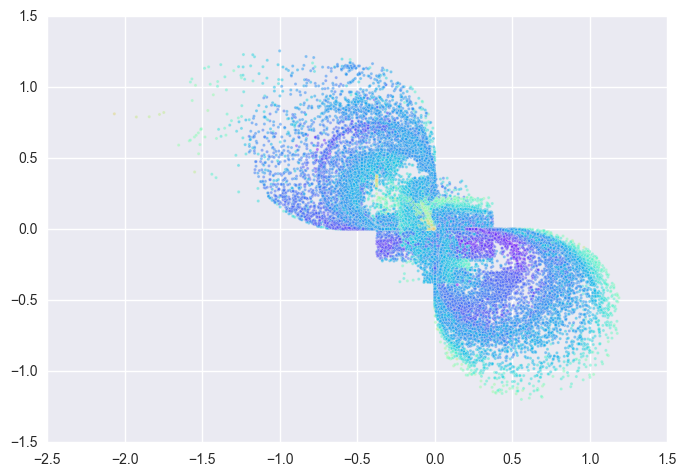

7


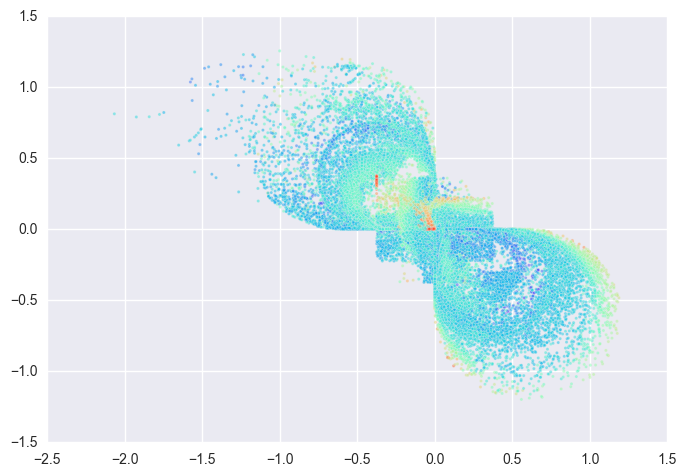

8


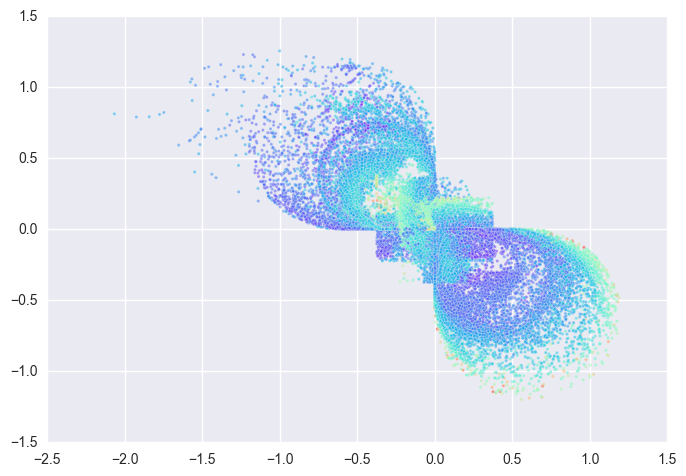

In [45]:
for i in range(9):
    print(i)
    plt.scatter(x, y, c=a[:,0,i], alpha=0.5, s=5, cmap="rainbow")
    plt.show()

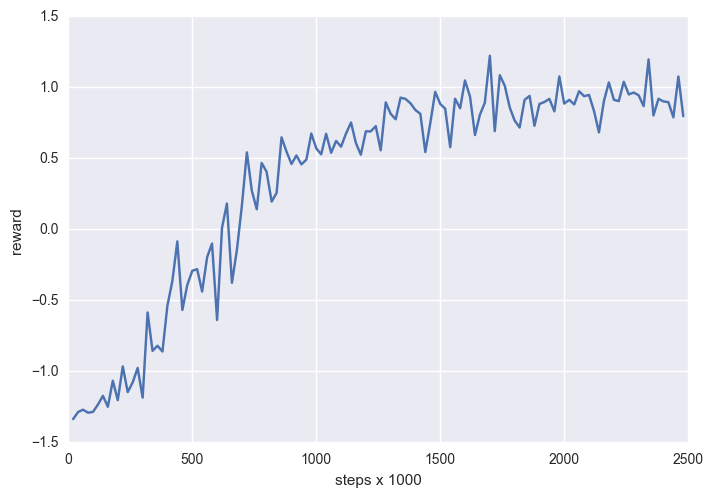

In [23]:
plt.plot([e[1]/1000 for e in episodes], [e[2] for e in episodes])
plt.xlabel('steps x 1000');plt.ylabel('reward')

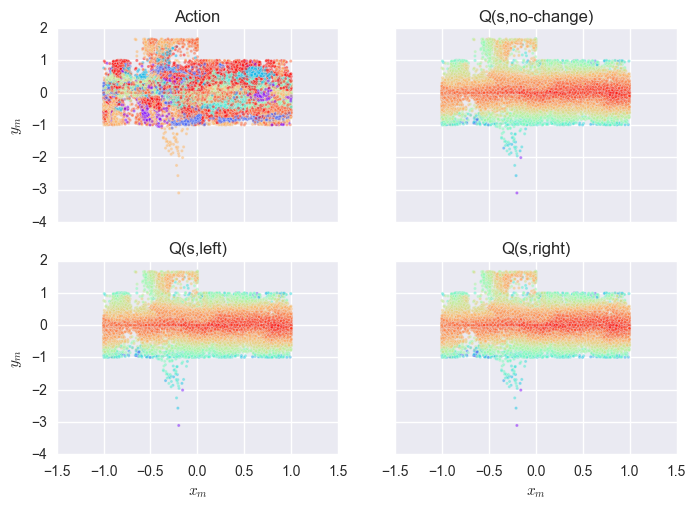

In [7]:
slice_plot(n=20000, size=5, alpha=0.5)
#plt.savefig('qslice.png', dpi=300)

---

In [9]:
while episode_number < 30000 and agent.steps < 2980000:
    episode_number += 1
    reward = run_episode(agent, render=False)
    reward_sum += reward
    
    if agent.steps >= last_batch_steps + BATCH_SIZE:
        reward_avg = reward_sum / (episode_number - last_batch_episode)
        last_batch_episode = episode_number
        last_batch_steps = int(agent.steps / BATCH_SIZE) * BATCH_SIZE
        episodes.append((episode_number, agent.steps, reward_avg))

        print('Episode: %d, steps: %d, epsilon: %f, average reward: %f.' \
              % (episode_number, agent.steps, agent.epsilon, reward_avg))
        
        if reward_avg > reward_best:
            reward_best = reward_avg
            agent.brain.model.save_model('best.mod', False)

        reward_sum = 0
       
agent.brain.model.save_model('last.mod', False)
print('Done.')

Episode: 806, steps: 20012, epsilon: 0.964170, average reward: -1.314449.
Episode: 1568, steps: 40005, epsilon: 0.929668, average reward: -1.267090.
Episode: 2316, steps: 60007, epsilon: 0.896400, average reward: -1.244711.
Episode: 3040, steps: 80006, epsilon: 0.864339, average reward: -1.227046.
Episode: 3743, steps: 100024, epsilon: 0.833410, average reward: -1.192490.
Episode: 4381, steps: 120006, epsilon: 0.803653, average reward: -1.094363.
Episode: 5019, steps: 140019, epsilon: 0.774927, average reward: -1.096916.
Episode: 5626, steps: 160011, epsilon: 0.747270, average reward: -1.045155.
Episode: 6252, steps: 180022, epsilon: 0.720588, average reward: -1.066209.
Episode: 6861, steps: 200021, epsilon: 0.694886, average reward: -1.040312.
Episode: 7435, steps: 220058, epsilon: 0.670068, average reward: -0.981508.
Episode: 7956, steps: 240078, epsilon: 0.646169, average reward: -0.860671.
Episode: 8452, steps: 260060, epsilon: 0.623179, average reward: -0.797081.
Episode: 8938, st

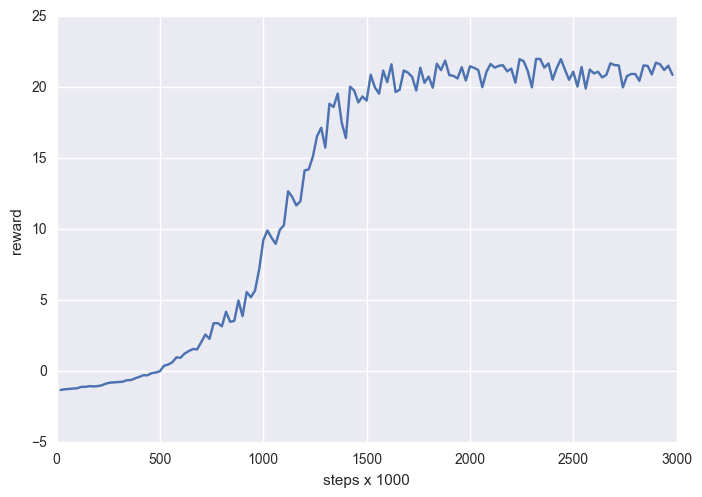

In [10]:
plt.plot([e[1]/1000 for e in episodes], [e[2] for e in episodes])
plt.xlabel('steps x 1000');plt.ylabel('reward')
plt.savefig('learning.png', dpi=300)

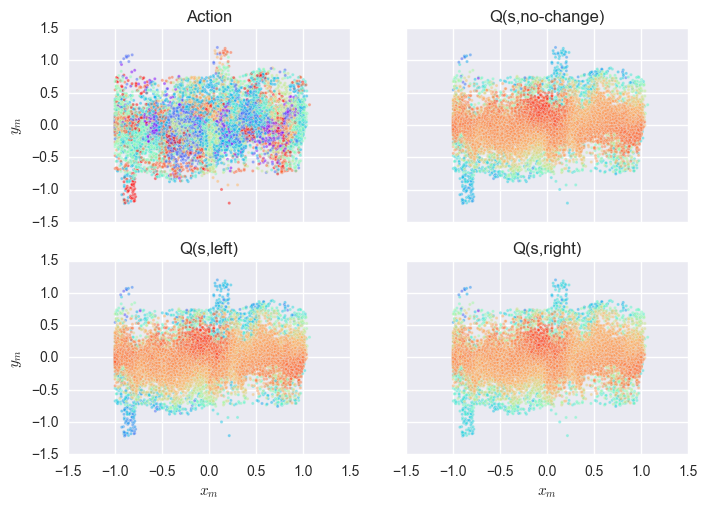

In [11]:
slice_plot(n=20000, size=5, alpha=0.5)
plt.savefig('qslice.png', dpi=300)

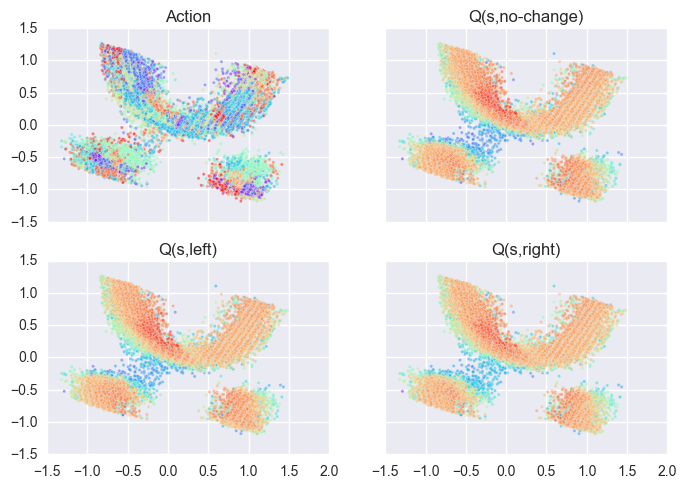

In [12]:
pca_plot(n=20000, size=5, alpha=0.5)
plt.savefig('pca.png', dpi=300)

### Exploration - exploitation trade-off

Note initiall $\epsilon$ is set to 1 which implies we are enitrely exploraing but as steps increase we reduce exploration and start leveraging the learnt space to collect rewards (a.k.a exploitation) as well.

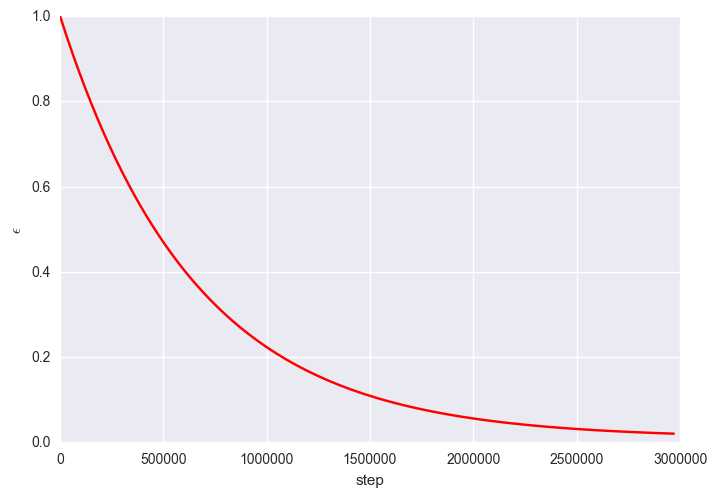

In [12]:
def epsilon(steps):
    return MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-LAMBDA * steps)

r = range(0,EXPLORATION_STOP,int(EXPLORATION_STOP/100))
plt.plot(r, [min(epsilon(x),1) for x in r], 'r')
#plt.plot(r, [min(epsilon(x),1)**EPSILON_TRAIN_FACTOR for x in r], 'b')
plt.xlabel('step');plt.ylabel('$\epsilon$')

## Discounted Reward

We tune $\gamma$ to look ahead only a short timespan, in which the current action is of significant importance.

0.995

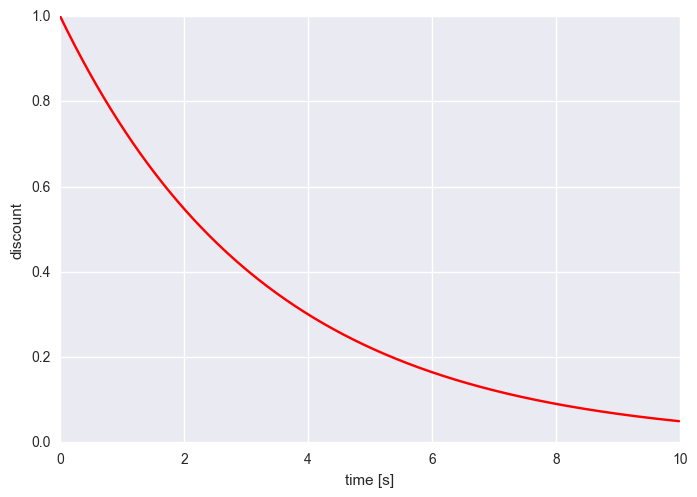

In [15]:
r = range(0,600)
plt.plot([t/60.0 for t in r], [GAMMA ** x for x in r], 'r')
plt.xlabel('time [s]');plt.ylabel('discount')
GAMMA